In [80]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
wd = '/Users/timvigers/Dropbox/Work/Viral Shah/Day and Night CGM/'

In [64]:
# Import data
df = pd.read_csv(wd+'Data_Clean/analysis_data.csv',usecols=['HbA1c','14 Day TIR','14 Night TIR'])
df.columns = ['a1c','day_tir','night_tir']
# Get row with most sensor values for each person in JDRF data
jdrf = pd.read_csv(wd+'Data_Clean/analysis_data_jdrf.csv')
idx = jdrf.groupby('id',sort=False)['sensor_readings'].transform(max) == jdrf['sensor_readings']
jdrf = jdrf[idx]
idx = jdrf["sensor_readings"] >= 2822 # 70% cutoff for 2 weeks of data
jdrf = jdrf[idx]
# Combine
jdrf = jdrf[['a1c','day_tir','night_tir']]
df = pd.concat([df,jdrf])

# Data Characteristics
- TIR was calculated using 2 weeks of CGM data prior to an office visit.
- For participants with multiple HbA1c measures, the CGM wear with the largest number of sensor readings was used. This was done to prevent auto-correlation between measures within a subject.
- CGM with < 70% wear were excluded.
- HbA1c was split into the following quintiles: (4.899, 6.2] < (6.2, 6.7] < (6.7, 7.3] < (7.3, 8.0] < (8.0, 13.5]

In [65]:
# Split into quintiles
df['a1c_group'] = pd.qcut(df['a1c'],5)
# Difference between day and night TIR
df['tir_diff'] = df['day_tir'] - df['night_tir']

## Mean Day and Night TIR by HbA1c Quintile

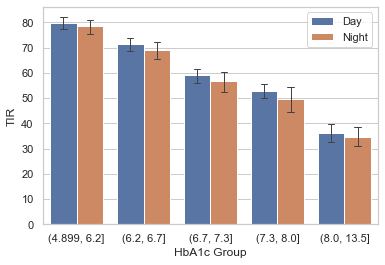

In [92]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_tir','night_tir'], value_name='TIR')
plot_df['variable'].replace({'day_tir':'Day','night_tir':'Night'},inplace=True)
# Plot
sns.set_theme(style="whitegrid")
plot = sns.barplot(x='a1c_group',y='TIR',hue='variable',data=plot_df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group')
plot.legend(title='');

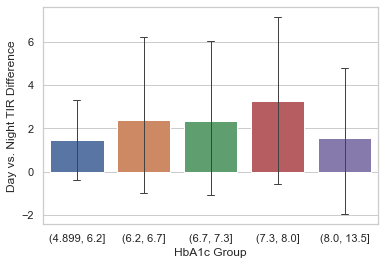

In [104]:
plot = sns.barplot(x='a1c_group',y='tir_diff',data=df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night TIR Difference');

Error bars indicate 95% confidence interval around the mean.

In [102]:
means = df.groupby(['a1c_group']).mean().drop('a1c', axis=1)
means.columns = ['Mean Day TIR','Mean Night TIR','Mean Day vs. Night TIR Difference']
means

,Mean Day TIR,Mean Night TIR,Mean Day vs. Night TIR Difference
a1c_group,,,
"(4.899, 6.2]",79.845783,78.377183,1.468600
"(6.2, 6.7]",71.287413,68.885929,2.401484
"(6.7, 7.3]",59.013201,56.663401,2.349800
"(7.3, 8.0]",52.797887,49.532942,3.264945
"(8.0, 13.5]",36.228310,34.668662,1.559649


## Correlation between HbA1c and TIR

In [105]:
pearsonr(df['day_tir'],df['a1c'])

(-0.8085808210403687, 5.275902781685542e-78)

In [85]:
from scipy.stats import spearmanr
spearmanr(df['day_tir'],df['a1c'])


SpearmanrResult(correlation=-0.8113612721983665, pvalue=6.058889572549373e-79)